In [1]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import pickle

from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

import sys
sys.path.append('../utils')
from pp_utils import *
from plot_utils import *

In [2]:
#import BDF and setting important parameters
raw_error = mne.io.read_raw_bdf('../data_raw/sub_03/sub_03_04.bdf')
fs = raw_error.info['sfreq']

events = mne.find_events(raw_error, shortest_event= 1)
events_2, events_3, events_4, events_5, events_6, trial_starts = sort_events(events)
#listen_pre_start, motor_pre_start, error_pre_start, listen_post_start, motor_post_start, error_post_start = events_6[:,0]/FS_ORIG

#raw_error_post = raw.copy().crop(tmin = )
#raw.info.ch_names
events_6

Extracting EDF parameters from /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_03/sub_03_04.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Trigger channel has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
47754 events found
Event IDs: [65282 65284 65286 65288 65290 65296 65298 65312 65314 65535]
All event types present


array([[209041,  65280,  65314]])

In [43]:
raw_error.times.max()

435.857421875

In [40]:
events_6

array([[209041,  65280,  65314]])

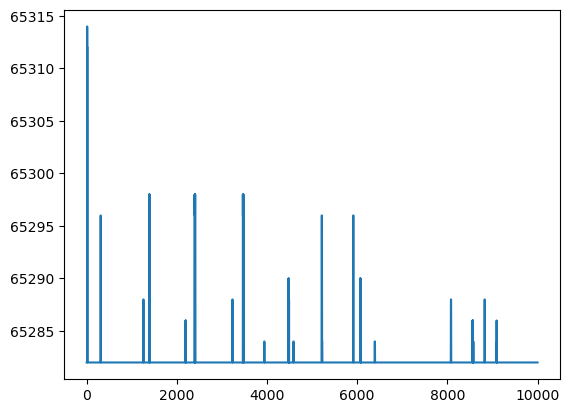

In [4]:
plt.plot(events[:,2][0:10000])

In [5]:
events_6

array([[209041,  65280,  65314]])

In [6]:
raw_error = raw_error.crop(tmin = events_6[0][0]/fs, tmax = raw_error.times.max()-5)

In [15]:
raw_error.preload = True

Trigger channel has a non-zero initial value of 65314 (consider using initial_event=True to detect this event)
47044 events found
Event IDs: [65282 65284 65286 65288 65290 65296 65298 65312]


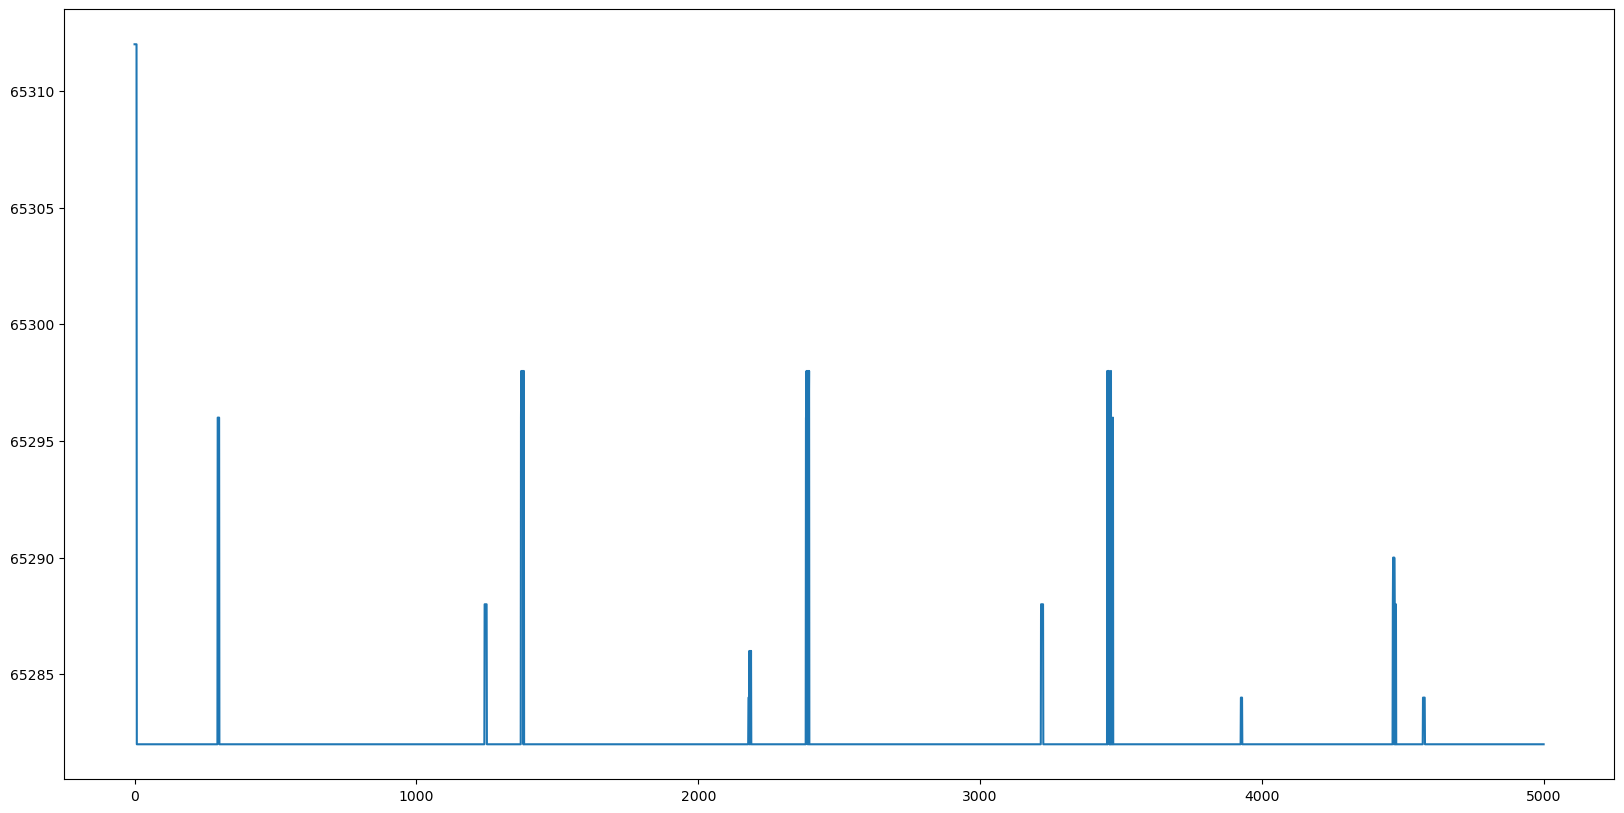

In [9]:
raw_error_events = mne.find_events(raw_error, shortest_event = 1)
plt.figure(figsize=(20,10))
plt.plot(raw_error_events[:, 2][0:5000])

In [26]:
ch_names = raw_error.info['ch_names']
ch_names

['Fp1',
 'AF7',
 'AF3',
 'F1',
 'F3',
 'F5',
 'F7',
 'FT7',
 'FC5',
 'FC3',
 'FC1',
 'C1',
 'C3',
 'C5',
 'T7',
 'TP7',
 'CP5',
 'CP3',
 'CP1',
 'P1',
 'P3',
 'P5',
 'P7',
 'P9',
 'PO7',
 'PO3',
 'O1',
 'Iz',
 'Oz',
 'POz',
 'Pz',
 'CPz',
 'Fpz',
 'Fp2',
 'AF8',
 'AF4',
 'AFz',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT8',
 'FC6',
 'FC4',
 'FC2',
 'FCz',
 'Cz',
 'C2',
 'C4',
 'C6',
 'T8',
 'TP8',
 'CP6',
 'CP4',
 'CP2',
 'P2',
 'P4',
 'P6',
 'P8',
 'P10',
 'PO8',
 'PO4',
 'O2',
 'M1',
 'M2',
 'LO1',
 'LO2',
 'IO1',
 'IO2',
 'SO1',
 'SO2',
 'GSR1',
 'GSR2',
 'Erg1',
 'Erg2',
 'Resp',
 'Plet',
 'Temp',
 'Status']

In [39]:

"""
Provides a single function to manually preprocess raw objects.

Reads from an mne raw file that has been pre-cropped.
You have to provide the subject ID and file name manually!

"""

import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append('../utils')
from pp_utils import *



def preprocess_manual(file, subject_ID, filename,
                      
    #------------------------------------------                
    #        PREPROCESSING PARAMETERS
    #------------------------------------------
    print_info = False, 

    # Notch filtering
    notch_applied = True, 
    freq_notch = 50, 

    # Bandpass filtering
    bpf_applied = True, 
    freq_low   = 0.01,
    freq_high  = 30,
    ftype = 'butter',
    order = 3,

    # Spherical interpolation
    int_applied = False,
    interpolation = 'spline',

    # Rereferencing using average of mastoids electrodes
    reref_applied = True,
    reref_type = 'Mastoids', #Mastoids #Average

    # Downsampling
    down_applied = True,
    downfreq = 128):
    
    #-----------------------------------------
    #        LOAD FILE
    #------------------------------------------

    raw = mne.io.read_raw_bdf(file, preload = True)

    FS_ORIG = raw.info['sfreq']
    ch_names = raw.info['ch_names']
    if not down_applied:
        downfreq = FS_ORIG
    downfreq_factor =int(FS_ORIG/downfreq)
    bandpass = str(freq_low) + '-' + str(freq_high)


    df_pre = pd.DataFrame()
    subject_ID = subject_ID


    events = mne.find_events(raw, stim_channel='Status', shortest_event=1) #raises exception if shortest event is default 2...?
    
    #trial start and end are indicated in channel 5, filtered for 10+ min duration
    #events_2, events_3, events_4, events_5, events_6, trial_starts = sort_events(events)

    #======================================================================================
    #                       FILTERING
    #======================================================================================
    ## -------------
    ## Select channels
    ## -------------
    eeg_channels = ch_names[0:72]
    eeg = raw.copy().pick_channels(eeg_channels)
    
 
    ## -------------
    ## Notch filtering
    ## -------------
    df_pre['notch_applied'] = [notch_applied]
    if notch_applied:
        eeg = eeg.notch_filter(freqs=freq_notch)
        df_pre['notch'] = [freq_notch]

    ## -------------
    ## BPFiltering
    ## -------------
    df_pre['bpf_applied'] = [bpf_applied]
    if bpf_applied:
        iir_params = dict(order=order, ftype=ftype)
        filter_params = mne.filter.create_filter(eeg.get_data(), eeg.info['sfreq'], 
                                                l_freq=freq_low, h_freq=freq_high, 
                                                method='iir', iir_params=iir_params)

        
        eeg = eeg.filter(l_freq=freq_low, h_freq=freq_high, method='iir', iir_params=iir_params)
        df_pre['bandpass'] = [iir_params]
        df_pre['HPF'] = [freq_low]
        df_pre['LPF'] = [freq_high]

        ## -------------
        ## Rereferencing
        ## -------------
        df_pre['reref_applied'] = [reref_applied]
        if reref_applied:
            # Set electrodes for rereferencing
            if reref_type == 'Mastoids':
                reref_channels = ['M1', 'M2']   
            else:
                reref_channels = 'average'           

            # Actually r-referencing signals
            eeg = eeg.set_eeg_reference(ref_channels=reref_channels)
            df_pre['reref_type'] = [reref_type]
            df_pre['reref_channels'] = [reref_channels]
         
        ## -------------
        ## Downsampling
        ## -------------
        df_pre['down_applied'] = [down_applied]
        df_pre['downfreq'] = [downfreq]
        if down_applied:
            eeg = eeg.resample(sfreq=downfreq)
         

        #======================================================================================
        #                      UPDATE TRIGGERS
        #======================================================================================
      
        #create support vectors
        #zero array with downsampled dimensions
        events_original = np.zeros((5, eeg.get_data().shape[1])) #5 rows = event types, along time axis zero when there is an event and 1 everywhere else
        
      
        #get triggers
        events_2, events_3, events_4, events_5, events_6, section_start = sort_events(events, clean = True)

        #get trial start time
        section_start = section_start[0][0]
        
        #find indices corrected for start time
        """
        indices_2 = (events_2[:,0]) - section_start
        indices_3 = (events_3[:,0]) - section_start
        indices_4 = (events_4[:,0]) - section_start
        indices_5 = (events_5[:,0]) - section_start   """
        indices_6 = (events_6[:,0]) - section_start   

        #populate event array with 1s where there are events
        """
        events_original[0][indices_2] = 1
        events_original[1][indices_3] = 1
        events_original[2][indices_4] = 1
        events_original[3][indices_5] = 1"""
        events_original[3][indices_6] = 1

        #resample while preserving events
        cropped_length = eeg.get_data().shape[1]
        events_resampled = np.zeros((5, cropped_length))
        for row in range(events_resampled.shape[0]):
            events_resampled[row] = discretize(events_original[row], final_length = cropped_length, downfreq_factor = downfreq_factor)
  


   
    #return events





event_test = preprocess_manual('../data_raw/sub_03/sub_03_04.bdf', '03', 'error_post')

    

Extracting EDF parameters from /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_03/sub_03_04.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 660479  =      0.000 ...   644.999 secs...
Trigger channel has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
47754 events found
Event IDs: [65282 65284 65286 65288 65290 65296 65298 65312 65314 65535]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoffs at 0.01, 30.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
All event types present


ValueError: could not broadcast input array from shape (10320,) into shape (82560,)

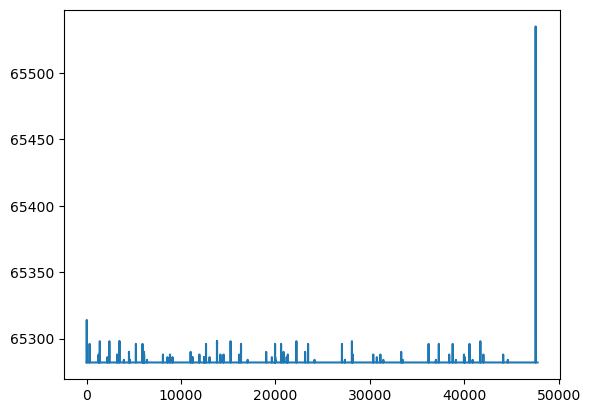

In [63]:
plt.plot(event_test[:,2])